In [2]:
import pandas as pd
import numpy as np
from mpi4py import MPI
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import sklearn 
from sklearn.datasets import make_blobs
import sys
from scipy.spatial import distance

In [3]:
from ipyparallel import Client, error
cluster=Client(profile="mpi")
view=cluster[:]
view.block=True
print(cluster.ids)
print(cluster)
view.activate()
#lview  = cluster.load_balanced_view()
#lview.block = True
CORES = len(cluster[:])
print(cluster[0])
%px

[0, 1, 2, 3, 4, 5, 6, 7]
<DirectView 0>


In [4]:
%px import socket
%px print("hosts:", socket.gethostname())


[stdout:0] hosts: SachleensMBP.local
[stdout:1] hosts: SachleensMBP.local
[stdout:2] hosts: SachleensMBP.local
[stdout:3] hosts: SachleensMBP.local
[stdout:4] hosts: SachleensMBP.local
[stdout:5] hosts: SachleensMBP.local
[stdout:6] hosts: SachleensMBP.local
[stdout:7] hosts: SachleensMBP.local


In [86]:

class K_means:
    def __init__(self, X = None, y= None, k_clusters = 8, max_iters = 300, n_iters = 10,):
        self.centers = []
        self.labels = []
        X = None
        y = None
        self.max_iters = max_iters
        self.n_iters = n_iters
        self.k_clusters = k_clusters
        self.centroids = None
        self.labels = None
        #self.tolerance = tolerance

    def print_c( k_clusters):
        from scipy.spatial import distance
        import numpy as np
        centroid_flags =  []
        for i in x_part:
            local_array = []
            for j in centroids:
                local_array.append(float(distance.euclidean(i,j)))
            centroid_flags.append(np.argmin(local_array))
#        return centroid_flags   


        #making arrays which hold the elements that are true for a certain cluster
        local_temp = list()
        for i in range(k_clusters):
            local_temp.append([])
        for i in range (len(x_part)):
            local_temp[centroid_flags[i]].append(x_part[i])
        
        
        #takes the mean of the k-cluster
        local_mean_1 = np.zeros((k_clusters,x_part.shape[1:][0]))
        for i in range(k_clusters):
            for j in range (x_part.shape[1:][0]):
                 if(local_temp[i] == []):
                    pass
                 else:
                    local_mean_1[i, j] = (np.array(local_temp[i])[:,j].mean())
                        #zeta= 1
        
        return local_mean_1  #local_centroids, now just gather and take mean
        
        
    def fit(self, X, k_clusters = 8, max_iters = 300, n_iters = 10):
        if isinstance(X, pd.DataFrame):
            #self.X = pd.DataFrame([X])
            X = X.to_numpy()
            #print(type(X))                                        #comment out
            print("shape",X.shape)                                 #comment out
            shape_ = X.shape[1:]
            #print(X)                                               #comment out
            print("--------------------------")
            
            
         #ranomly picking k points from X   
        #centroid_flags = np.zeros(shape_)
        random_indices = np.random.choice(X.shape[0], size=k_clusters, replace=False)
        centroids = X[random_indices]
        print("random_centroids", centroids)
        print()
        view.scatter("x_part",X)
        for i in range(max_iters):
            view['centroids'] = centroids   #braodcast
            ar = view.apply(K_means.print_c, k_clusters)# gathers for us
            #new_centroids = np.zeros((k_clusters))
            new_centroids = np.zeros((k_clusters,np.array(ar[0])[1:,].shape[1]))
            for i in range(k_clusters): 
                for j in range (np.array(ar[0])[1:,].shape[1]):
                    new_centroids[i,j] = np.array(ar)[:, i][:, j].mean()
            
            
            #find sum of squared errors i.e. use the formula two blocks down, between the centroids and the x_parts
            
            #centroids = new_centroids
            #print(new_centroids)
        
        self.centroids = new_centroids
        return new_centroids
    
    def calculations(s_centroids):
        from scipy.spatial import distance
        import numpy as np
        centroid_flags =  []
        for i in x_part_1:
            local_array = []
            for j in s_centroids:
                local_array.append(float(distance.euclidean(i,j)))
            centroid_flags.append(np.argmin(local_array))
        
        labels_local = centroid_flags
        return np.array(labels_local)   #reinstate
        #return counter
        
        
        #new_labels = view.pull("labels_local").get()
    
    def predict(self, X):
        import numpy as np
        if isinstance(X, pd.DataFrame):
            #self.X = pd.DataFrame([X])
            X = X.to_numpy()
            #print(type(X))                                        #comment out
            print("shape",X.shape)                                 #comment out
            shape_ = X.shape[1:]
            #print(X)                                               #comment out
            print("--------------------------")
        centroids = self.centroids
        labels = np.full((X.shape), -1)
        view.scatter("x_part_1",X)
        view.scatter("labels_local", labels)
        view['centroids'] = self.centroids   #braodcast 
        new_labels = view.apply(K_means.calculations, self.centroids)
        new_labels = np.array(new_labels).flatten()
        return new_labels
    
    
    
    
    
    

In [312]:
if __name__ == "__main__":
        centers = [(-3,-3), (3,3), (-3,3), (3,-3)]
        X, y = make_blobs(n_samples=1000, centers=centers, n_features=2, random_state=0)
        X = pd.DataFrame(X)
        shape_ = X.shape[1:]
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        start_time = time()
        a = K_means()
        x = a.fit(X_train, k_clusters = 4, max_iters = 300)
        output = (a.predict(X_test))
        print(time()- start_time)

shape (800, 2)
--------------------------
random_centroids [[ 2.9851423   3.82140594]
 [-3.46886419 -5.20144129]
 [-4.07934317  2.88577445]
 [ 3.81797761 -3.27891428]]

shape (200, 2)
--------------------------
12.843768119812012


In [313]:
count = 0
for i in range (len(output)):
    if (output[i] == y_test[i]):
        count+=1

print(count/len(output))

0.54


In [314]:
x

array([[ 2.87512327,  2.96883682],
       [-3.03277602, -3.0869238 ],
       [-2.9202392 ,  2.9023368 ],
       [ 2.91611905, -2.94350628]])

In [315]:
centers = np.array(centers)
centers

array([[-3, -3],
       [ 3,  3],
       [-3,  3],
       [ 3, -3]])

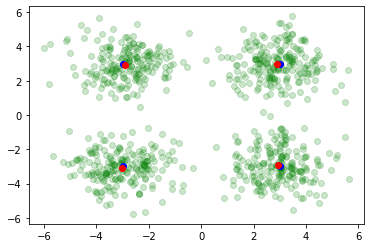

In [316]:
plt.scatter(X_train.iloc[:,0], X_train.iloc[:, 1], alpha = 0.2, c='g')
#plt.scatter(X_test.iloc[:,0], X_test.iloc[:, 1], c='y', alpha=0.3)
plt.scatter(centers[:, 0], centers[:, 1], c='b' )
plt.scatter(x[:, 0], x[:, 1], c='r' )
#